In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pickle
from scipy import stats
from scipy.stats import gamma, gaussian_kde
import seaborn as sns
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

In [2]:
colors = ['#2878B5', '#9AC9DB', '#F8AC8C', '#C82423', '#FF8884']
def np_std(data, p = 0.95):
    mean = np.mean(data)
    std_err = stats.sem(data)
    margin_of_error = std_err * stats.t.ppf((1 + p) / 2, len(data) - 1)
    confidence_interval = (mean - margin_of_error, mean + margin_of_error)
    return confidence_interval

In [3]:
china_map = gpd.read_file('Data/maps/2023年地级/地级.shp')
china_province_map = gpd.read_file('Data/maps/2023年省级/省级.shp')
jiuduanxian = gpd.read_file('Data/maps/九段线/九段线.shp')
guojie = gpd.read_file('Data/maps/国界/国家矢量.shp')
city_to_prov = dict(zip(china_map['地名'], china_map['省级']))

## Fig. S5

In [4]:
# human basic met
base_met = 0.863

walk_met = 3.5  # 16060
bike_met = 6.8  #  01011
drive_met = 2.0  # 16010
bus_met = 1.3  # 16016

walk_speed = 0.08 # 4.8km/h, 80m/min
bike_speed = 9.7/60
drive_speed = 0.5
bus_speed = 0.25

walk_speed_sigma = 0.5 / 60
bike_speed_sigma = 3.0 / 60
drive_speed_sigma = 5.0 / 60
bus_speed_sigma = 5.0 / 60

# The proportion of each mode under a travel distance is the overall mode proportion weighted by the gamma PDF
def mode_pick(d):
    ps = np.array([0.3, 0.12, 0.28, 0.3])
    p_walk = gamma.pdf(d, a = 1.47, scale = 0.96/1.47)
    p_bike = gamma.pdf(d, a = 1.64, scale = 2.76/1.64)
    p_car = gamma.pdf(d, a = 1.25, scale = 9.17/1.25)
    p_bus = gamma.pdf(d, a = 1.57, scale = 9.03/1.57)
    p_mode = np.array([p_walk, p_bike, p_car, p_bus])
    return ps * p_mode / np.sum(ps * p_mode)

# average MET under distance d: d * met(mode) / speed(mode)
def met_uncertain_95(d, repeat = 100000):
    y = mode_pick(d)
    ys = y[0] * walk_met * d / np.clip(np.random.normal(walk_speed, walk_speed_sigma, repeat), 0.01, 0.15) + y[1] * bike_met * d / np.clip(np.random.normal(bike_speed, bike_speed_sigma, repeat), 0.02, 0.3) + y[2] * drive_met * d / np.clip(np.random.normal(drive_speed, drive_speed_sigma, repeat), 0.1, 0.9) + y[3] * bus_met * d / np.clip(np.random.normal(bus_speed, bus_speed_sigma, repeat), 0.05, 0.45)
    return np.percentile(ys, [2.5, 97.5]), np.mean(ys)

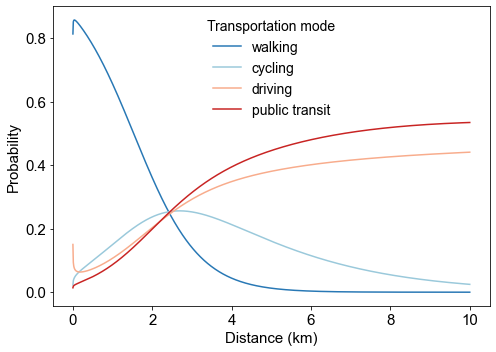

In [5]:
x = np.linspace(0.001, 10, 1000)
y = list(map(mode_pick, x))
plt.figure(figsize = (7, 5))
plt.plot(x, [x[0] for x in y], label = 'walking', color = colors[0])
plt.plot(x, [x[1] for x in y], label = 'cycling', color = colors[1])
plt.plot(x, [x[2] for x in y], label = 'driving', color = colors[2])
plt.plot(x, [x[3] for x in y], label = 'public transit', color = colors[3])
plt.legend(title = 'Transportation mode', frameon = False, fontsize = 14, title_fontsize = 14)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.ylabel('Probability', size = 15)
plt.xlabel('Distance (km)', size = 15)
plt.tight_layout()
plt.show()

In [6]:
# human basic met
base_met = 0.863

# change with temperature
def E1(x):
    return 0.07*x*x - 4.03*x+116.07
def HI_calib(x):
    if x <= 30:
        return 1
    else:
        return E1(x) / E1(28)

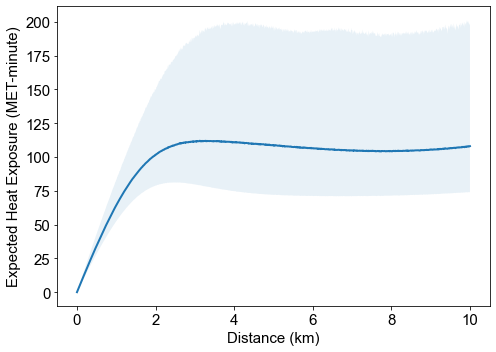

In [7]:
x = np.linspace(0.001, 10, 1000)
y_uncertain = list(map(met_uncertain_95, x))
plt.figure(figsize = (7, 5))
plt.plot(x, np.array([d[1] for d in y_uncertain]) * 2 * base_met, lw = 2)
plt.fill_between(x, np.array([d[0][0] for d in y_uncertain]) * 2 * base_met, np.array([d[0][1] for d in y_uncertain]) * 2 * base_met, alpha = 0.1)
plt.ylabel('Expected Heat Exposure (MET-minute)', size = 15)
plt.xlabel('Distance (km)', size = 15)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.tight_layout()
plt.show()

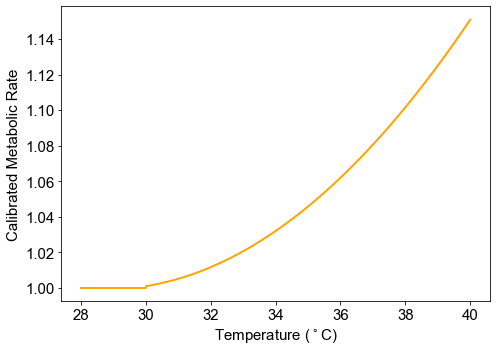

In [8]:
plt.figure(figsize = (7, 5))
x = np.linspace(28, 40, 1000)
y = list(map(HI_calib, x))
plt.plot(x, y, lw = 2, color = 'orange')
plt.ylabel('Calibrated Metabolic Rate', size = 15)
plt.xlabel('Temperature ($^\circ$C)', size = 15)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.tight_layout()
plt.show()

## Fig. S6 - per order heat exposure by province

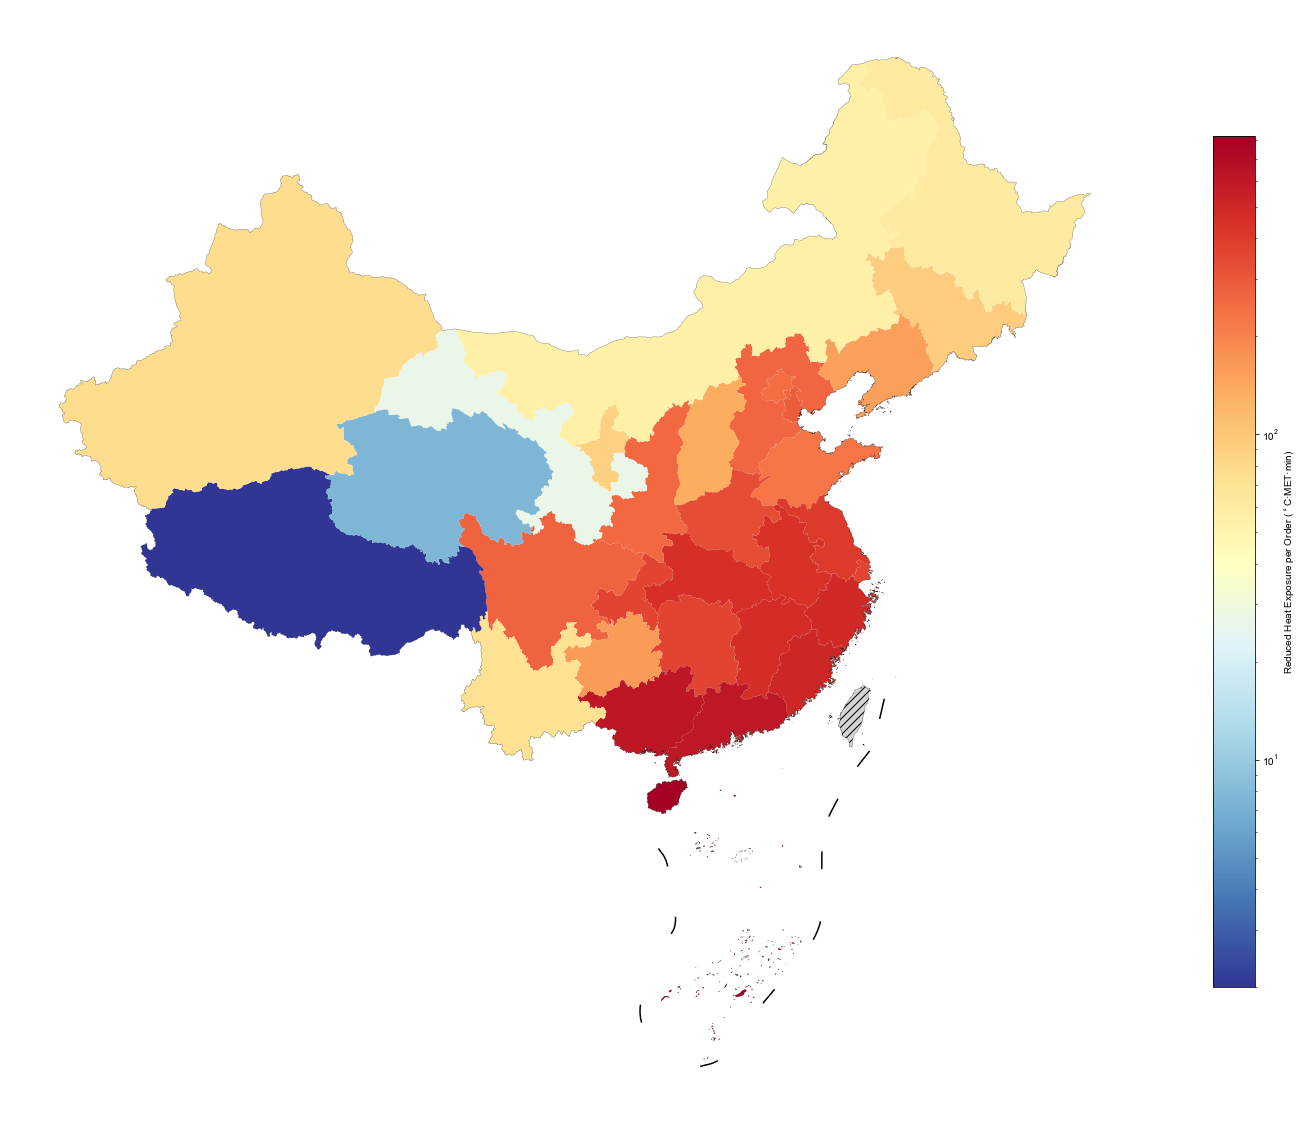

In [9]:
with open('Data/mean_MET_byprovince.pkl', 'rb') as f:
    province_mean_met = pickle.load(f)

china_map2 = pd.merge(china_province_map, province_mean_met, left_on = '省', right_on = 'province', how = 'left')
china_map2['MET'] = china_map2['MET'].clip(lower = 1) * 2
fig, ax = plt.subplots(figsize = (20, 20))
china_map2.to_crs('EPSG:3857').plot(ax = ax, column = 'MET', legend=True, cmap = 'RdYlBu_r', norm=matplotlib.colors.LogNorm(vmin=china_map2.MET.min(), vmax=china_map2.MET.max()),
       legend_kwds={"location":"right","shrink":.6,'label':'Reduced Heat Exposure per Order ($^\circ$C·MET·min)'},   missing_kwds = {'color': 'lightgrey', 'hatch': '///'})
guojie.to_crs('EPSG:3857').boundary.plot(ax = ax, color = 'black', lw = 0.2)
jiuduanxian.to_crs('EPSG:3857').plot(ax = ax, color = 'black')
ax.axis('off')
plt.tight_layout()
plt.show()

## Fig. 3a

In [10]:
df = pd.read_csv('Data/temp_HI.csv')

In [11]:
x = np.array(df.max_temp).reshape(-1, 1)
y = np.array(df.MET).reshape(-1, 1)
xystack = np.vstack([df.max_temp, df.MET])
z = gaussian_kde(xystack)(xystack)
idx = z.argsort()
x, y, z = df.max_temp.iloc[idx], df.MET.iloc[idx], z[idx]

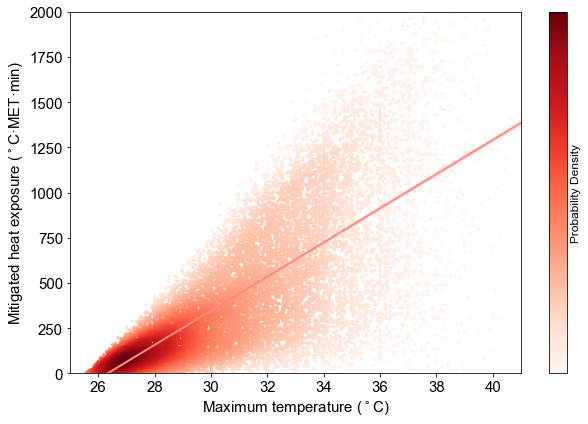

In [12]:
fig, ax = plt.subplots(figsize = (9, 6))
plt.scatter(x, y, s = 5, c = z, cmap = 'Reds')
cbar = plt.colorbar(ticks = [])
cbar.set_label(label = r'Probability Density', fontdict = {'size': 12})
sns.regplot(ax = ax, data = df, x = 'max_temp', y ='MET', scatter = False, line_kws = {'lw': 2, 'color': colors[4]})
plt.ylabel('Mitigated heat exposure ($^\circ$C·MET·min)', size = 15)
plt.xlabel('Maximum temperature ($^\circ$C)', size = 15)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.xlim(25, 41)
plt.ylim(0, 2000)
plt.tight_layout()
plt.show()

## Fig. 3b

In [13]:
with open('Data/user_total_exposure.pkl', 'rb') as f:
    user_tot_exp = pickle.load(f)

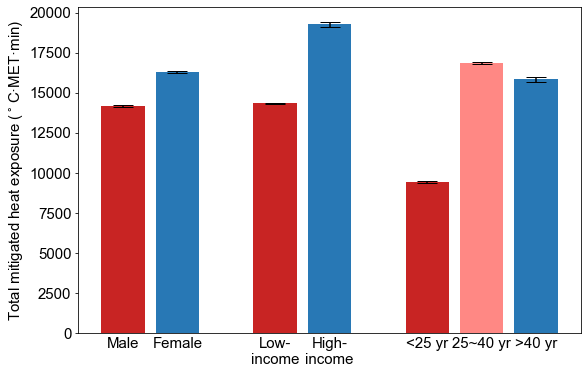

In [14]:
fig, ax = plt.subplots(figsize = (9, 6))
x = np.mean(user_tot_exp['female'].MET * 2)
plt.bar([-1.6], [x], color = colors[0])
l, u = np_std(user_tot_exp['female'].MET * 2)
plt.errorbar([-1.6], [x], yerr = ([x-l], [u-x]), color ='black', capsize = 10)
x = np.mean(user_tot_exp['male'].MET * 2)
plt.bar([-2.6], [x], color = colors[3])
l, u = np_std(user_tot_exp['male'].MET * 2)
plt.errorbar([-2.6], [x], yerr = ([x-l], [u-x]), color ='black', capsize = 10)
x = np.mean(user_tot_exp['highincome'].MET * 2)
plt.bar([1.2], [x], color = colors[0])
l, u = np_std(user_tot_exp['highincome'].MET * 2)
plt.errorbar([1.2], [x], yerr = ([x-l], [u-x]), color ='black', capsize = 10)
x = np.mean(user_tot_exp['lowincome'].MET * 2)
plt.bar([0.2], [x], color = colors[3])
l, u = np_std(user_tot_exp['lowincome'].MET * 2)
plt.errorbar([0.2], [x], yerr = ([x-l], [u-x]), color ='black', capsize = 10)
x = np.mean(user_tot_exp['agehigh'].MET * 2)
plt.bar([5], [x], color = colors[0])
l, u = np_std(user_tot_exp['agehigh'].MET * 2)
plt.errorbar([5], [x], yerr = ([x-l], [u-x]), color ='black', capsize = 10)
x = np.mean(user_tot_exp['agemid'].MET * 2)
plt.bar([4], [x], color = colors[4])
l, u = np_std(user_tot_exp['agemid'].MET * 2)
plt.errorbar([4], [x], yerr = ([x-l], [u-x]), color ='black', capsize = 10)
x = np.mean(user_tot_exp['agelow'].MET * 2)
plt.bar([3], [x], color = colors[3])
l, u = np_std(user_tot_exp['agelow'].MET * 2)
plt.errorbar([3], [x], yerr = ([x-l], [u-x]), color ='black', capsize = 10)
plt.xticks([])
plt.ylabel('Total mitigated heat exposure ($^\circ$C·MET·min)', size = 15)
ax.tick_params(axis = 'x', length = 0)
plt.yticks(size = 15)
plt.xticks([-1.6, -2.6, 1.2,0.2,5,4,3], ['Female', 'Male', 'High-\nincome', 'Low-\nincome', '>40 yr', '25~40 yr', '<25 yr'], size = 15)
plt.show()

## Fig. 3c

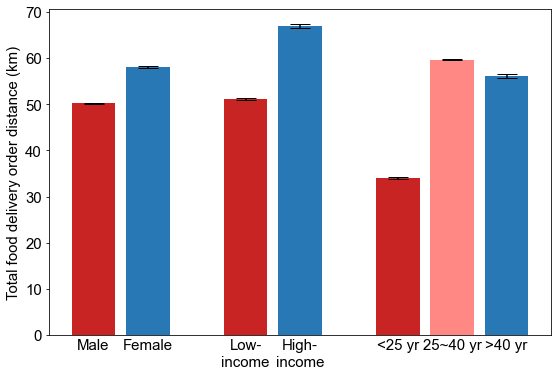

In [15]:
fig, ax = plt.subplots(figsize = (9, 6))
x = np.mean(user_tot_exp['female'].direct_distance)
plt.bar([-1.6], [x], color = colors[0])
l, u = np_std(user_tot_exp['female'].direct_distance)
plt.errorbar([-1.6], [x], yerr = ([x-l], [u-x]), color ='black', capsize = 10)
x = np.mean(user_tot_exp['male'].direct_distance)
plt.bar([-2.6], [x], color = colors[3])
l, u = np_std(user_tot_exp['male'].direct_distance)
plt.errorbar([-2.6], [x], yerr = ([x-l], [u-x]), color ='black', capsize = 10)
x = np.mean(user_tot_exp['highincome'].direct_distance)
plt.bar([1.2], [x], color = colors[0])
l, u = np_std(user_tot_exp['highincome'].direct_distance)
plt.errorbar([1.2], [x], yerr = ([x-l], [u-x]), color ='black', capsize = 10)
x = np.mean(user_tot_exp['lowincome'].direct_distance)
plt.bar([0.2], [x], color = colors[3])
l, u = np_std(user_tot_exp['lowincome'].direct_distance)
plt.errorbar([0.2], [x], yerr = ([x-l], [u-x]), color ='black', capsize = 10)
x = np.mean(user_tot_exp['agehigh'].direct_distance)
plt.bar([5], [x], color = colors[0])
l, u = np_std(user_tot_exp['agehigh'].direct_distance)
plt.errorbar([5], [x], yerr = ([x-l], [u-x]), color ='black', capsize = 10)
x = np.mean(user_tot_exp['agemid'].direct_distance)
plt.bar([4], [x], color = colors[4])
l, u = np_std(user_tot_exp['agemid'].direct_distance)
plt.errorbar([4], [x], yerr = ([x-l], [u-x]), color ='black', capsize = 10)
x = np.mean(user_tot_exp['agelow'].direct_distance)
plt.bar([3], [x], color = colors[3])
l, u = np_std(user_tot_exp['agelow'].direct_distance)
plt.errorbar([3], [x], yerr = ([x-l], [u-x]), color ='black', capsize = 10)

plt.xticks([])
plt.ylabel('Total food delivery order distance (km)', size = 15)
ax.tick_params(axis = 'x', length = 0)
plt.yticks(size = 15)
plt.xticks([-1.6, -2.6, 1.2,0.2,5,4,3], ['Female', 'Male', 'High-\nincome', 'Low-\nincome', '>40 yr', '25~40 yr', '<25 yr'], size = 15)
plt.show()

## Fig. 3d~f

In [16]:
with open('Data/user_total_exposure_bydemographic.pkl', 'rb') as f:
    demog_tot_exp = pickle.load(f)

In [17]:
daily_max_temp_df = pd.read_csv('Data/climate_allcities_avg.csv')
daily_max_temp_df['dt'] = pd.to_datetime(daily_max_temp_df['dt'], format='%Y-%m-%d')

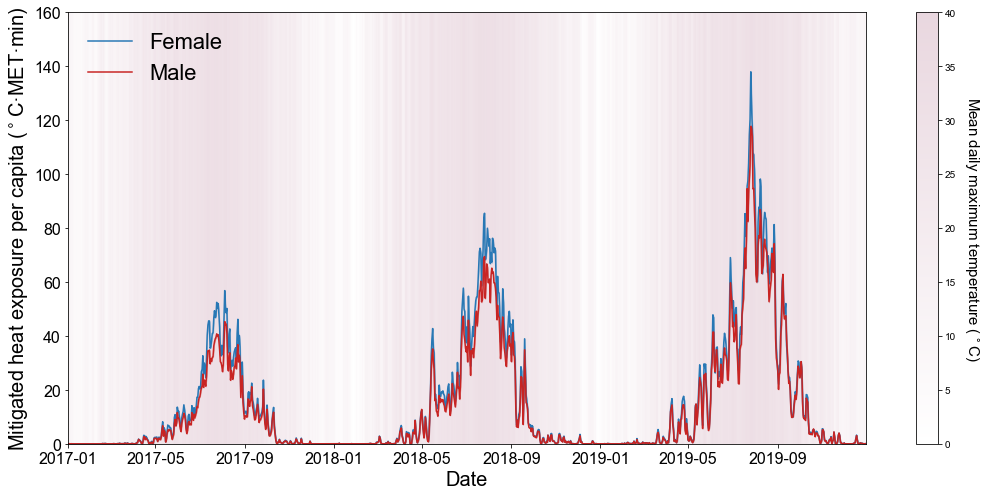

In [18]:
fig, ax = plt.subplots(figsize = (15, 7))
ymax = 160
ax.plot(demog_tot_exp['female'].set_index('dt').MET_M, color = colors[0], zorder = 1, label = 'Female')
ax.fill_between(demog_tot_exp['female'].set_index('dt').index, demog_tot_exp['female'].set_index('dt').MET_L, demog_tot_exp['female'].set_index('dt').MET_H, color = colors[0], alpha = 0.3)
ax.plot(demog_tot_exp['male'].set_index('dt').MET_M, color = colors[3], zorder = 1, label = 'Male')
ax.fill_between(demog_tot_exp['male'].set_index('dt').index, demog_tot_exp['male'].set_index('dt').MET_L, demog_tot_exp['male'].set_index('dt').MET_H, color = colors[3], alpha = 0.3)


ax.set_xlabel('Date', size = 20)
ax.set_ylabel('Mitigated heat exposure per capita ($^\circ$C·MET·min)', size = 20, color = 'black')
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
for_plot = daily_max_temp_df[daily_max_temp_df.dt<='2019-12-31'].set_index('dt')
data_x = list(for_plot.index)
data_hight = [ymax] * for_plot.shape[0]
data_color = list(for_plot.max_temp)
data_color = [x / 40 for x in data_color]
my_cmap = LinearSegmentedColormap.from_list('fasdasdf', ['#FFFFFF', '#e9d7df'])
colors_me = my_cmap(data_color)
rects = ax.bar(data_x, data_hight, width = 1, color=colors_me, zorder = 0, alpha = 1)
sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,40))
sm.set_array([])
cbar = plt.colorbar(sm, ax = ax)
cbar.set_label('Mean daily maximum temperature ($^\circ$C)', rotation=270,labelpad=25, fontsize = 15)
ax.set_ylim(0, ymax)
ax.set_xlim(for_plot.index.min(), for_plot.index.max())
plt.legend(fontsize = 22, frameon = False, loc = 'upper left')
plt.tight_layout()
plt.show()

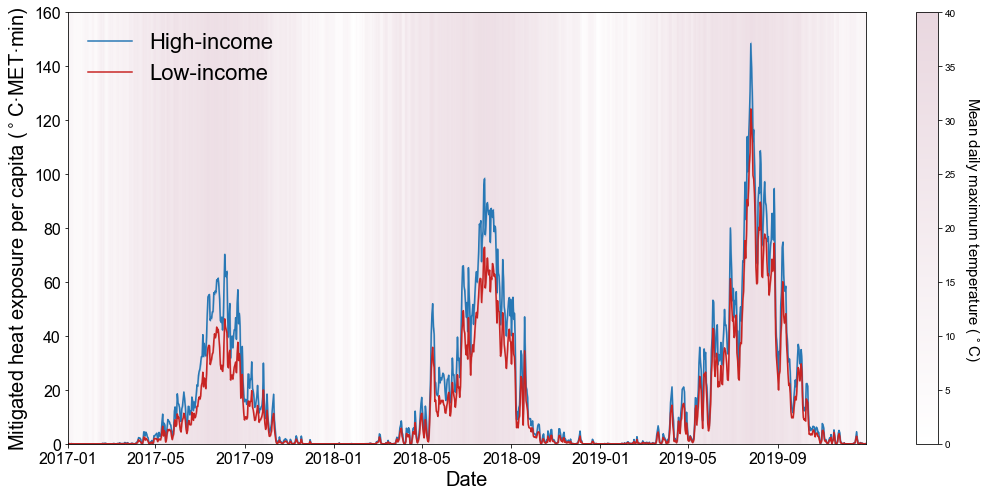

In [19]:
fig, ax = plt.subplots(figsize = (15, 7))
ymax = 160
ax.plot(demog_tot_exp['highincome'].set_index('dt').MET_M, color = colors[0], zorder = 1, label = 'High-income')
ax.fill_between(demog_tot_exp['highincome'].set_index('dt').index, demog_tot_exp['highincome'].set_index('dt').MET_L, demog_tot_exp['highincome'].set_index('dt').MET_H, color = colors[0], alpha = 0.3)
ax.plot(demog_tot_exp['lowincome'].set_index('dt').MET_M, color = colors[3], zorder = 1, label = 'Low-income')
ax.fill_between(demog_tot_exp['lowincome'].set_index('dt').index, demog_tot_exp['lowincome'].set_index('dt').MET_L, demog_tot_exp['lowincome'].set_index('dt').MET_H, color = colors[3], alpha = 0.3)
ax.set_xlabel('Date', size = 20)
ax.set_ylabel('Mitigated heat exposure per capita ($^\circ$C·MET·min)', size = 20, color = 'black')
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
for_plot = daily_max_temp_df[daily_max_temp_df.dt<='2019-12-31'].set_index('dt')
data_x = list(for_plot.index)
data_hight = [ymax] * for_plot.shape[0]
data_color = list(for_plot.max_temp)
data_color = [x / 40 for x in data_color]
my_cmap = LinearSegmentedColormap.from_list('fasdasdf', ['#FFFFFF', '#e9d7df'])
colors_me = my_cmap(data_color)
rects = ax.bar(data_x, data_hight, width = 1, color=colors_me, zorder = 0, alpha = 1)
sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,40))
sm.set_array([])
cbar = plt.colorbar(sm, ax = ax)
cbar.set_label('Mean daily maximum temperature ($^\circ$C)', rotation=270,labelpad=25, fontsize = 15)
ax.set_ylim(0, ymax)
ax.set_xlim(for_plot.index.min(), for_plot.index.max())
plt.legend(fontsize = 22, frameon = False, loc = 'upper left')
plt.tight_layout()
plt.show()

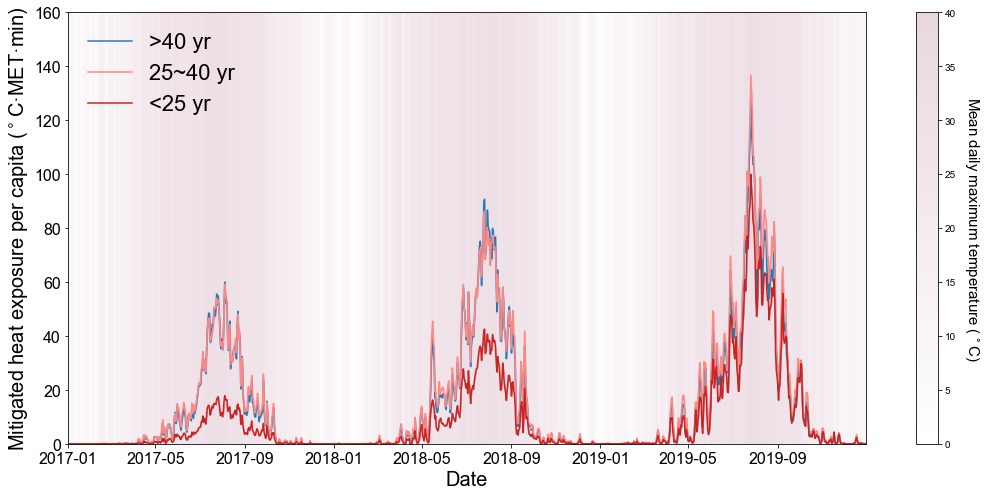

In [20]:
fig, ax = plt.subplots(figsize = (15, 7))
ymax = 160
ax.set_xlabel('Date', size = 20)
ax.plot(demog_tot_exp['agehigh'].set_index('dt').MET_M, color = colors[0], label = '>40 yr')
ax.fill_between(demog_tot_exp['agehigh'].set_index('dt').index, demog_tot_exp['agehigh'].set_index('dt').MET_L, demog_tot_exp['agehigh'].set_index('dt').MET_H, color = colors[0], alpha = 0.3)
ax.plot(demog_tot_exp['agemid'].set_index('dt').MET_M, color = colors[4], label = '25~40 yr')
ax.fill_between(demog_tot_exp['agemid'].set_index('dt').index, demog_tot_exp['agemid'].set_index('dt').MET_L, demog_tot_exp['agemid'].set_index('dt').MET_H, color = colors[4], alpha = 0.3)
ax.plot(demog_tot_exp['agelow'].set_index('dt').MET_M, color = colors[3], label = '<25 yr')
ax.fill_between(demog_tot_exp['agelow'].set_index('dt').index, demog_tot_exp['agelow'].set_index('dt').MET_L, demog_tot_exp['agelow'].set_index('dt').MET_H, color = colors[3], alpha = 0.3)
ax.set_ylabel('Mitigated heat exposure per capita ($^\circ$C·MET·min)', size = 20, color = 'black')
ax.set_ylim(0, None)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
for_plot = daily_max_temp_df[daily_max_temp_df.dt<='2019-12-31'].set_index('dt')
data_x = list(for_plot.index)
data_hight = [ymax] * for_plot.shape[0]
data_color = list(for_plot.max_temp)
data_color = [x / 40 for x in data_color]
# my_cmap = plt.cm.get_cmap('Reds')
my_cmap = LinearSegmentedColormap.from_list('fasdasdf', ['#FFFFFF', '#e9d7df'])
colors_me = my_cmap(data_color)
rects = ax.bar(data_x, data_hight, width = 1, color=colors_me, zorder = 0, alpha = 1)
sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,40))
sm.set_array([])
cbar = plt.colorbar(sm, ax = ax)
cbar.set_label('Mean daily maximum temperature ($^\circ$C)', rotation=270,labelpad=25, fontsize = 15)
ax.set_ylim(0, ymax)
ax.set_xlim(for_plot.index.min(), for_plot.index.max())
plt.legend(fontsize = 22, frameon = False, loc = 'upper left')
plt.tight_layout()
plt.show()